## Imports

In [1]:
import os
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from analysis.chiefinvestigation import Chiefinvestigator
from analysis.sindy_autoencoder import control_autoencoder, utils
from jax.experimental import optimizers
from jax import random
import time
import pickle

os.chdir("../../")  # remove if you want to search for ids in the analysis directory
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Generate Training and Testing Data from Episodes
One Episode of InvertedPendulum (MuJoCoEnv) lasts 1000 timesteps. E.g. 500 episodes generate 500,000 
timesteps to be used as training and testing datasets.


`dx` is computed using `np.gradient()`. This is equivalent to `pysindy.FiniteDifference()`. It is worth noting however
that e.g. `MuJoCo` can introduce some noise into the data. Although this is considered negligible for small enivorenments,
it may be advised to go with a method that is more robust towards noisy data.

In [2]:
agent_id = 1607352660 # inverted pendulum no vel, continuous action

chiefinv = Chiefinvestigator(agent_id)
# collect data from episodes
n_episodes = 500
activations_all_episodes, inputs_all_episodes, actions_all_episodes, states_all_episodes, _ \
    = chiefinv.get_data_over_episodes(n_episodes, "policy_recurrent_layer", chiefinv.get_layer_names()[1])
print(f"SIMULATED {n_episodes} episodes")

# create training and testing datasets
training_size = int(len(inputs_all_episodes) * 0.8)
dx = np.gradient(activations_all_episodes, axis=0)
training_data = {'x': activations_all_episodes[:training_size, :],
                 'dx': dx[:training_size, :],
                 'u': inputs_all_episodes[:training_size, :]}
testing_data = {'x': activations_all_episodes[training_size:, :],
                'dx': dx[training_size:, :],
                'u': inputs_all_episodes[training_size:, :]}
# TODO: visualize the data

storage/saved_models/states//1607352660
Loading from iteration best.
Using CombiWrapper('StateNormalizationWrapper', 'RewardNormalizationWrapper') for preprocessing.
SIMULATED 500 episodes


## Set up SindyControlAutoencoder 

In [4]:
layers = [64, 32, 8, 4]
poly_order = 2
lib_size = utils.library_size(layers[-1], poly_order, include_control=True)
key = random.PRNGKey(123)

thresholding_frequency, coefficient_theshold = 500, 0.1
hps = {'system_loss_coeff': 1,
       'control_loss_coeff': 1,
       'dx_loss_weight': 1e-4,
       'dz_loss_weight': 1e-6,
       'reg_loss_weight': 1e-5}

batch_size = 5000
num_batches = int(jnp.ceil(len(training_data['x']) / batch_size))
import pickle
init_params, coefficient_mask = control_autoencoder.build_sindy_control_autoencoder(layers, lib_size, key)
training_data_file = open("training_data.pkl", "wb")
pickle.dump(training_data, training_data_file)#
training_data_file.close()

testing_data_file = open("testing_data.pkl", "wb")
pickle.dump(testing_data, testing_data_file)
testing_data_file.close()

## Plot Coefficients and Coefficient Mask
For now `sindy coefficients` and `coefficient mask` are homogenously initalized to `1`.

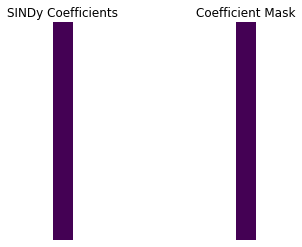

In [5]:
control_autoencoder.plot_params(init_params, coefficient_mask)

## Set up Optimizer

In [6]:
learning_rate = 1e-3
opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(init_params)

## Train the networks

In [7]:
n_epochs, n_refine_epochs = 5000, 1000
print_every = 200 # epochs
all_train_losses = []

start_time = time.time()
for epoch in range(n_epochs):
    for batch in range(num_batches):
        ids = utils.batch_indices(batch, num_batches, batch_size)
        opt_state = control_autoencoder.update_jit(batch, opt_state, opt_update, get_params,
                                                   training_data['x'][ids, :],
                                                   training_data['dx'][ids, :],
                                                   training_data['u'][ids, :], coefficient_mask, hps)

    params = get_params(opt_state)
    if epoch % thresholding_frequency == 0 and epoch > 1:
        coefficient_mask = jnp.abs(params['sindy_coefficients']) > coefficient_theshold
        print("Updated coefficient mask")

    all_train_losses.append(control_autoencoder.loss_jit(params,
                                                         training_data['x'][:batch_size, :],
                                                         training_data['dx'][:batch_size, :],
                                                         training_data['u'][:batch_size, :], coefficient_mask, hps))
    if epoch % print_every == 0:
        utils.print_update(all_train_losses[-1]['total'], epoch, epoch*num_batches, time.time() - start_time)
        start_time = time.time()

print(f"FINISHING TRAINING...\n"
      f"Sparsity: {jnp.sum(coefficient_mask)} active terms")

all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

Epoch 0 | Loss 0.46327731013298035 | Updates 0 | This took: 4.6211s
Epoch 200 | Loss 0.04317479953169823 | Updates 16000 | This took: 46.2679s
Epoch 400 | Loss 0.017954399809241295 | Updates 32000 | This took: 45.8835s
Updated coefficient mask
Epoch 600 | Loss 0.006877200212329626 | Updates 48000 | This took: 51.7295s
Epoch 800 | Loss 0.005032400134950876 | Updates 64000 | This took: 46.8002s
Updated coefficient mask
Epoch 1000 | Loss 0.00432930001989007 | Updates 80000 | This took: 44.9742s
Epoch 1200 | Loss 0.003848399966955185 | Updates 96000 | This took: 45.6287s
Epoch 1400 | Loss 0.0033903999719768763 | Updates 112000 | This took: 44.872s
Updated coefficient mask
Epoch 1600 | Loss 0.003104900009930134 | Updates 128000 | This took: 45.0123s
Epoch 1800 | Loss 0.0029206001199781895 | Updates 144000 | This took: 44.9468s
Updated coefficient mask
Epoch 2000 | Loss 0.0027618000749498606 | Updates 160000 | This took: 44.9007s
Epoch 2200 | Loss 0.0026476001366972923 | Updates 176000 | Thi

## Plot Training Losses

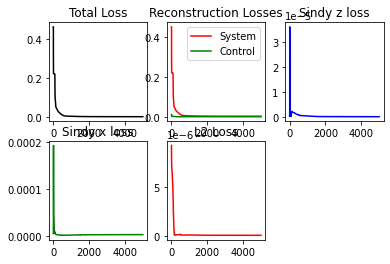

In [8]:
time_steps = np.linspace(0, n_epochs, n_epochs)
plt.figure()
plt.subplot(231)
plt.plot(time_steps, all_train_losses['total'], 'k')
plt.title('Total Loss')

plt.subplot(232)
plt.plot(time_steps, all_train_losses['sys_loss'], 'r', label='System')
plt.plot(time_steps, all_train_losses['control_loss'], 'g', label='Control')
plt.legend()
plt.title('Reconstruction Losses')

plt.subplot(233)
plt.plot(time_steps, all_train_losses['sindy_z_loss'], 'b')
plt.title('Sindy z loss')

plt.subplot(234)
plt.plot(time_steps, all_train_losses['sindy_x_loss'], 'g')
plt.title('Sindy x loss')

plt.subplot(235)
plt.plot(time_steps, all_train_losses['sindy_regularization_loss'], 'r')
plt.title('L2 Loss')
plt.show()

## Refinement Training

In [12]:
hps['reg_loss_weight'] = 0 # no regularization
print('REFINEMENT...')
all_refine_losses = []

start_time = time.time()
for epoch in range(n_refine_epochs):
    for batch in range(num_batches):
        ids = utils.batch_indices(batch, num_batches, batch_size)
        opt_state = control_autoencoder.update_jit(batch, opt_state, opt_update, get_params,
                                                   training_data['x'][ids, :],
                                                   training_data['dx'][ids, :],
                                                   training_data['u'][ids, :], coefficient_mask, hps)

    all_refine_losses.append(control_autoencoder.loss_jit(get_params(opt_state),
                                                          training_data['x'][:batch_size, :],
                                                          training_data['dx'][:batch_size, :],
                                                          training_data['u'][:batch_size, :], coefficient_mask, hps))
    if epoch % print_every == 0:
        utils.print_update(all_refine_losses[-1]['total'], epoch, epoch*num_batches, time.time() - start_time)
        start_time = time.time()

all_refine_losses = {k: [dic[k] for dic in all_refine_losses] for k in all_refine_losses[0]}

REFINEMENT...
Epoch 0 | Loss 0.0022718999534845352 | Updates 0 | This took: 3.8022s
Epoch 200 | Loss 0.002261300105601549 | Updates 16000 | This took: 45.26s
Epoch 400 | Loss 0.0022517999168485403 | Updates 32000 | This took: 44.9182s
Epoch 600 | Loss 0.002242499962449074 | Updates 48000 | This took: 44.9137s
Epoch 800 | Loss 0.0022354000248014927 | Updates 64000 | This took: 44.8805s


## Testing

In [13]:
params = get_params(opt_state)
test_batch_size = 10000 # 10 episodes
test_loss = control_autoencoder.loss_jit(params,
                                         testing_data['x'][:test_batch_size, :],
                                         testing_data['dx'][:test_batch_size, :],
                                         testing_data['u'][:test_batch_size, :],
                                         coefficient_mask, hps)['total']
print(f"Loss on large test batch: {round(test_loss, 6)}")

Loss on large test batch: 0.0020939998794347048


## Visualizations

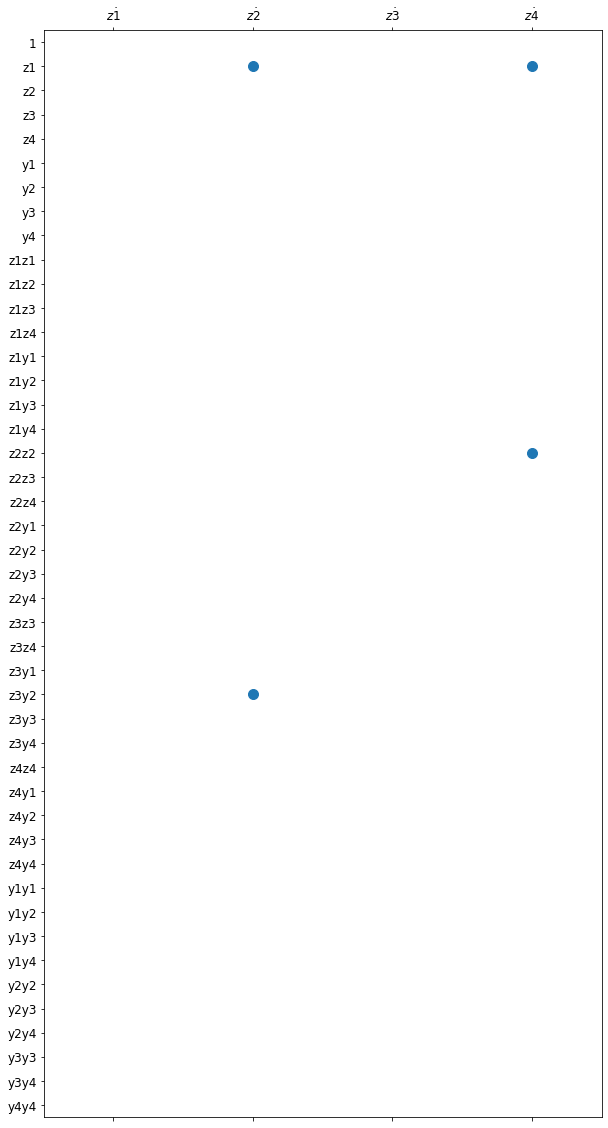

In [14]:
zlabels = ['z1', 'z2', 'z3', 'z4']
ulabels = ['y1', 'y2', 'y3', 'y4']
latex_labels = [r'$\dot{z1}$', r'$\dot{z2}$', r'$\dot{z3}$', r'$\dot{z4}$']
xlabels, ylabels = utils.generate_labels(zlabels, ulabels, poly_order)

fig= plt.figure(figsize=(10, 20))
plt.spy(coefficient_mask * params['sindy_coefficients'],
        marker='o', markersize=10, aspect='auto')
plt.xticks([0, 1, 2, 3], latex_labels, size=12)
yticks = list(np.arange(len(coefficient_mask)))
plt.yticks(yticks, ylabels, size=12)
plt.show()
#plt.subplot(122)
#plt.imshow(coefficient_mask * params['sindy_coefficients'])
#plt.axis('off')
#plt.colorbar()
#plt.show()

In [15]:
# Print Sparse State Equations
from sympy import symbols
theta_syms = symbols(ylabels)
dz_syms = symbols(latex_labels)

expr = np.matmul(theta_syms, coefficient_mask * params['sindy_coefficients'])
print(expr)

[0 -0.21060086786747*z1 + 0.288454979658127*z3y2 0
 0.230849623680115*z1 + 0.152435258030891*z2z2]


In [ ]:
# Visualize Dynamics
vis_batch_size = 2000

In [ ]:
# Interpret latent variables

## Plug in SindySystem
Let the Sindy dynamics compute actions to be applied in the environment.

In [ ]:
# do it with submodelfrom and submodelto